<a href="https://colab.research.google.com/github/michaellmy/17_website/blob/master/LearningToCompare_best_cat_fix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning to Compare (Using NN layers) #
Suppose we are given two images $x_1$ and $x_2$, and we would like like to compare which image looks better than the other.

We will learn a mapping from each image $x$ to a scalar scores using $s(x) = f(x;θ)$ where
$f(x)$ might be (for example) a neural network with input $x$ and scalar output

## Comparing cats vs dogs

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%matplotlib inline
import cv2
import glob
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import zipfile
import natsort
import os 
from PIL import Image

np.random.seed(42)
random.seed(42)

input_size = (224, 224) # EfficientNet input size
raw_data = '/content/drive/MyDrive/dataset/dogs-vs-cats.zip'

with zipfile.ZipFile(raw_data, 'r') as zip_ref:
    zip_ref.extractall('raw_data')

# Training data
with zipfile.ZipFile('raw_data/train.zip', 'r') as zip_ref:
    zip_ref.extractall('cats-dogs')

# Testing data
with zipfile.ZipFile('raw_data/test1.zip', 'r') as zip_ref:
    zip_ref.extractall('cats-dogs')

In [3]:
def resize(dir, input_size):
  output = []
  for myFile in dir:
    image = cv2.imread (myFile)
    res = cv2.resize(image, dsize=input_size, interpolation=cv2.INTER_CUBIC)
    output.append(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
  return output

In [4]:
# Resizing training images
dog_datas = resize(sorted(glob.glob('cats-dogs/train/dog*.jpg'))[:1000], input_size)
cat_datas = resize(sorted(glob.glob('cats-dogs/train/cat*.jpg'))[:1000], input_size)

print(len(dog_datas), len(cat_datas))

1000 1000


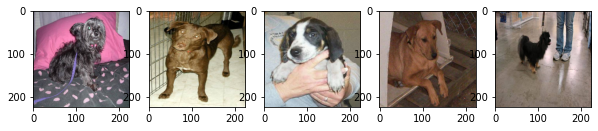

In [5]:
fig = plt.figure(figsize=(10, 8))
for i in range(0, 5):
    ax = plt.subplot(1, 5, i+1)
    plt.imshow(dog_datas[i].astype("uint8"))

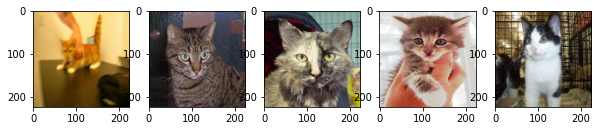

In [6]:
fig = plt.figure(figsize=(10, 8))
for i in range(0, 5):
    ax = plt.subplot(1, 5, i+1)
    plt.imshow(cat_datas[i].astype("uint8"))

In [7]:
# Shuffling positions between X and Y
N = 500
n_features = 1280
X_data = dog_datas[:N//2] + cat_datas[N//2:N]
Y_data = cat_datas[:N//2] + dog_datas[N//2:N]

# Make user preferences [0,0,0,0,0,.....,1,1,1,1,1,] s.t. dogs=0, cats=1
C = np.zeros(shape=(len(X_data),n_features))
for i in range (N//2, N):
    C[i] = [1] * len(C[i])

len(X_data), len(Y_data)

(500, 500)

In [8]:
# Get f(x) from EfficientNet / Other pre-trained models
from tensorflow.keras.applications import EfficientNetB0, MobileNetV2, VGG19, DenseNet201
efficientnetb0 = EfficientNetB0(weights='imagenet', include_top=True)
#efficientnetb0 = VGG19(weights='imagenet', include_top=True)

def get_network_output(image):
  layer_output = tf.keras.models.Model(
      inputs=efficientnetb0.inputs,
      outputs=efficientnetb0.layers[-2].output,
  )
  return layer_output(image)

output_images_X = get_network_output(np.array(X_data))
output_images_Y = get_network_output(np.array(Y_data))

output_images_X.shape, output_images_Y.shape

(TensorShape([500, 1280]), TensorShape([500, 1280]))

In [9]:
theta = tf.random.Generator.from_seed(1)
theta = tf.Variable(theta.normal(shape=[n_features,1]))
theta

<tf.Variable 'Variable:0' shape=(1280, 1) dtype=float32, numpy=
array([[ 0.43842274],
       [-0.53439844],
       [-0.07710262],
       ...,
       [-1.8838558 ],
       [ 1.3883139 ],
       [-1.0113807 ]], dtype=float32)>

In [10]:
def neg_loglikelihood():
  log_likelihood = 1 / N * tf.reduce_sum(tf.math.log(tf.sigmoid((2 * C - 1) * (tf.transpose(theta) * output_images_X - tf.transpose(theta) * output_images_Y))))
  return -log_likelihood

opt = tf.keras.optimizers.SGD(learning_rate=0.5)
epochs = 501
for i in range(epochs):
  opt.minimize(neg_loglikelihood, var_list=[theta])
  if i % 100 == 0:
    print('Loss at epoch {} = {}'.format(i,neg_loglikelihood().numpy()))

Loss at epoch 0 = 908.1245727539062
Loss at epoch 100 = 794.6473999023438
Loss at epoch 200 = 787.9745483398438
Loss at epoch 300 = 786.3328857421875
Loss at epoch 400 = 785.7299194335938
Loss at epoch 500 = 785.4584350585938


In [11]:
print("Training score of image X vs. image Y:")
for i in range(len(X_data)):
  if i % 50 == 0:
      print('Pair {}: {:.2f}, {:.2f}'.format(i, np.matmul(tf.transpose(theta), output_images_X[i])[0], np.matmul(tf.transpose(theta), output_images_Y[i])[0]))

Training score of image X vs. image Y:
Pair 0: 12.01, 290.36
Pair 50: -222.43, 312.10
Pair 100: -231.39, 400.73
Pair 150: -282.52, 423.43
Pair 200: -330.80, 427.23
Pair 250: 447.27, -148.10
Pair 300: 350.11, -239.85
Pair 350: 449.03, -269.96
Pair 400: 442.72, -293.82
Pair 450: 319.97, -8.69


In [12]:
# Prepare and resize testing dataset
testing_All = glob.glob('cats-dogs/test1/*.jpg')
random.shuffle(testing_All)

testing_dataset = resize(testing_All[:10], input_size)

In [13]:
output_test = get_network_output(np.array(testing_dataset))

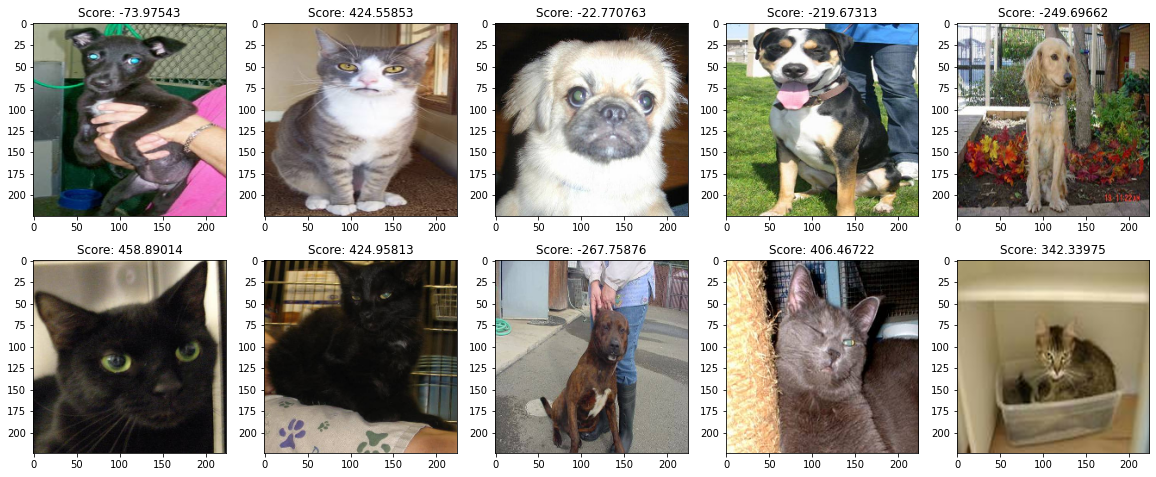

In [14]:
fig = plt.figure(figsize=(20, 8))
for i in range(len(output_test)):
    ax = plt.subplot(2, 5, i+1)
    #print("Score of {}: {}".format(testing_All[i].split("/")[-2:], np.matmul(tf.transpose(theta), output_test[i])[0]))
    plt.title('Score: ' + str(np.matmul(tf.transpose(theta), output_test[i])[0]))
    plt.imshow(testing_dataset[i].astype("uint8"))

In [15]:
theta

<tf.Variable 'Variable:0' shape=(1280, 1) dtype=float32, numpy=
array([[-0.08248384],
       [ 2.847918  ],
       [ 4.8292966 ],
       ...,
       [ 0.78669566],
       [ 4.6344795 ],
       [-0.00925062]], dtype=float32)>

## Comparing between real and GAN-generated cats ##

Instead of a cats vs dogs classifier, we now use real cats vs GAN-generated cats

In [16]:
# Training data
raw_data_gan = '/content/drive/MyDrive/dataset/cats_gans.zip'
with zipfile.ZipFile(raw_data_gan, 'r') as zip_ref:
    zip_ref.extractall('raw_data_gan')

cats_gans = resize(sorted(glob.glob('raw_data_gan/001000/*.png')), input_size)

# Testing dataset
raw_data_gan_test = '/content/drive/MyDrive/dataset/cats_gans_test.zip'
with zipfile.ZipFile(raw_data_gan_test, 'r') as zip_ref:
    zip_ref.extractall('raw_data_gan_test')
    
cats_gans_test = resize(sorted(glob.glob('raw_data_gan_test/077000/*.png'))[:600], input_size)

print(len(cats_gans), len(cats_gans_test))

1000 600


In [17]:
# Training real vs GAN-generated cat images
N = 500
X_data = cat_datas[:N//2] + cats_gans[N//2:N]
Y_data = cats_gans[:N//2] + cat_datas[N//2:N]

# Make user preferences [1,1,1,1,1,.....,0,0,0,0,0], s.t. dogs=1, cats=0
C = np.ones(shape=(len(X_data),n_features))
for i in range (N//2, N):
    C[i] = [0] * len(C[i])

len(X_data), len(Y_data)

(500, 500)

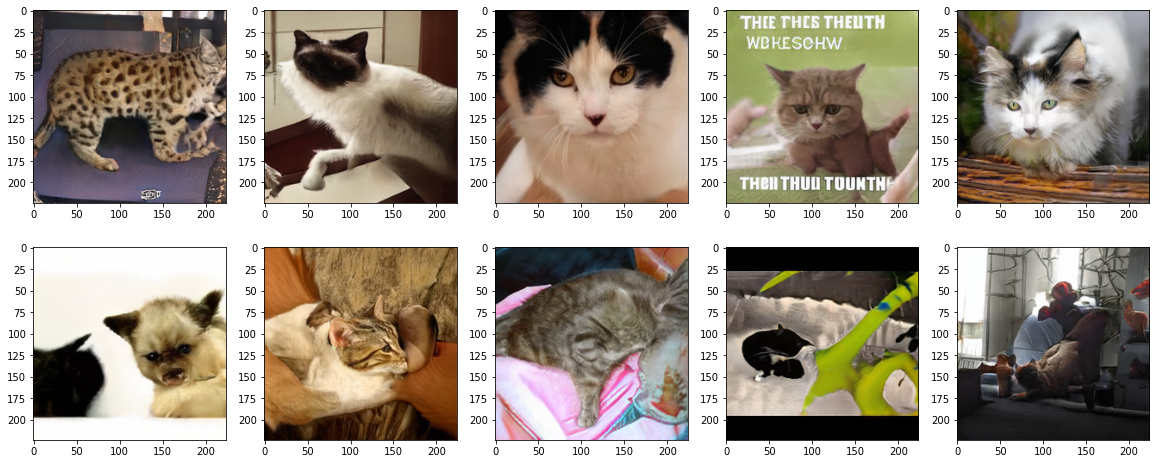

In [18]:
# Plot GAN-generated cats
fig = plt.figure(figsize=(20, 8))
for i in range(0, 10):
    ax = plt.subplot(2, 5, i+1)
    plt.imshow(Y_data[i].astype("uint8"))

In [19]:
output_images_X = get_network_output(np.array(X_data))
output_images_Y = get_network_output(np.array(Y_data))

In [20]:
# Re-training and updating theta
def neg_loglikelihood_opt():
  log_likelihood = 1 / N * tf.reduce_sum(tf.math.log(tf.sigmoid((2 * C - 1) * (tf.transpose(theta) * output_images_X - tf.transpose(theta) * output_images_Y))))
  return -log_likelihood

opt = tf.keras.optimizers.SGD(learning_rate=0.5)
epochs = 501
for i in range(epochs):
  opt.minimize(neg_loglikelihood_opt, var_list=[theta])
  if i % 100 == 0:
    print('Loss at epoch {} = {}'.format(i,neg_loglikelihood_opt().numpy()))

Loss at epoch 0 = 954.4389038085938
Loss at epoch 100 = 871.0217895507812
Loss at epoch 200 = 867.7994384765625
Loss at epoch 300 = 867.0008544921875
Loss at epoch 400 = 866.685546875
Loss at epoch 500 = 866.5394287109375


In [21]:
output_GANS_test = get_network_output(np.array(cats_gans_test))

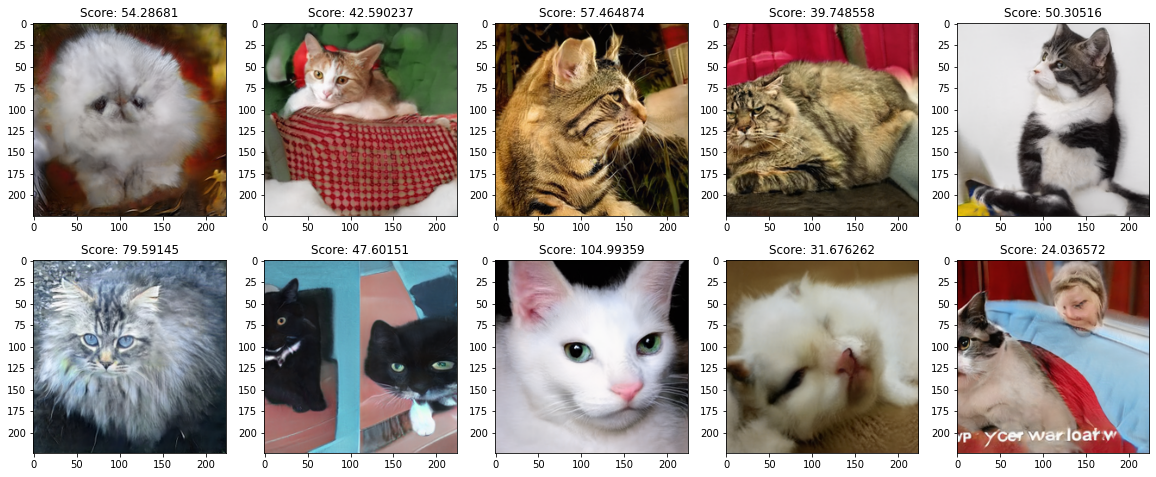

In [22]:
fig = plt.figure(figsize=(20, 8))
for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    plt.title('Score: ' + str(np.matmul(tf.transpose(theta), output_GANS_test[i])[0]))
    plt.imshow(cats_gans_test[i].astype("uint8"))

Scores of top 10 best cat images:


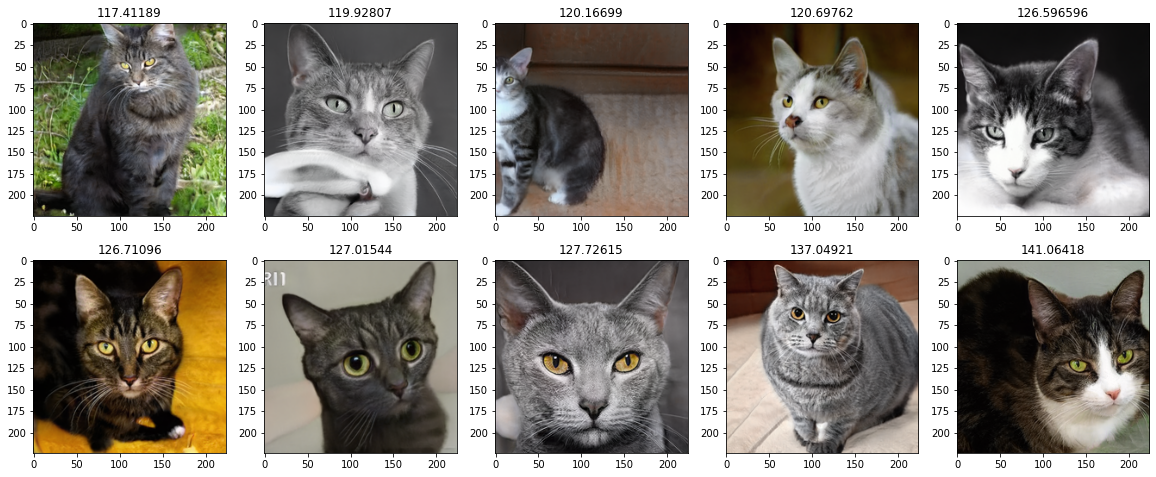

In [23]:
def recalculate_scores(theta):
    all_scores = {}
    for i in range(len(output_GANS_test)):
        score = np.matmul(tf.transpose(theta), output_GANS_test[i])[0]
        all_scores[score] = cats_gans_test[i].astype("uint8")

    fig = plt.figure(figsize=(20, 8))
    i = 0
    for k, v in sorted(all_scores.items())[-10:]:
        ax = plt.subplot(2, 5, i+1)
        plt.title(k)
        plt.imshow(v)
        i += 1

print("Scores of top 10 best cat images:")
recalculate_scores(theta)

In [24]:
theta

<tf.Variable 'Variable:0' shape=(1280, 1) dtype=float32, numpy=
array([[-0.41740844],
       [ 0.14818126],
       [ 0.58575267],
       ...,
       [ 0.54805076],
       [-0.8519686 ],
       [-2.6557403 ]], dtype=float32)>

In [25]:
def calculate_dir_scores(output_dir):
  total = 0
  for i in range(len(output_dir)):
    total += np.matmul(tf.transpose(theta), output_dir[i])[0]
  #print(total)
  return total

# Active Training Loop #

Given $\theta$, we can now obtain a score for each image in the dataset. To further optimize $\theta$, we can now take images with similar scores (i.e. model is unsure which is the better image), then use human preferences to label between pairs of images with similar scores. 

We can retrain the model with these new human labels, and keep looping and repeating this process of active learning, constantly updating $\theta$ to produce the best $\theta$ based on human preferences.

In [26]:
output_dir = 'outputs'
pathx_low = "dirX_low"
pathy_low = "dirY_low"

output_x = '/content/drive/MyDrive/dataset/dirX_low.zip'
output_y = '/content/drive/MyDrive/dataset/dirY_low.zip'

with zipfile.ZipFile(output_x, 'r') as zip_ref:
    zip_ref.extractall('{}'.format(output_dir))

with zipfile.ZipFile(output_y, 'r') as zip_ref:
    zip_ref.extractall('{}'.format(output_dir))

In [27]:
X_loop_dir = natsort.natsorted(glob.glob(os.path.join(output_dir, pathx_low, '*.png')))
X_loop = resize(X_loop_dir, input_size)

Y_loop_dir = natsort.natsorted(glob.glob(os.path.join(output_dir, pathy_low, '*.png')))
Y_loop = resize(Y_loop_dir, input_size)

len(X_loop), len(Y_loop)

(53, 53)

In [28]:
# Adjust additional labels after user
posOnes = [3,4,5,6,7,8,12,13,19,20,24,25,28,29,30,31,32,33,34,36,37,38,39,41,42,45,47,49,50,51,53]
ones = [pos - 1 for pos in posOnes]
M = min(len(X_loop), len(Y_loop))

D = np.zeros(shape=(M,n_features))
for i in ones:
    D[i] = [1] * len(D[i])

output_X_loop = get_network_output(np.array(X_loop[:M]))
output_Y_loop = get_network_output(np.array(Y_loop[:M]))
output_X_loop.shape, output_Y_loop.shape

(TensorShape([53, 1280]), TensorShape([53, 1280]))

In [29]:
print("Scores of human-labelled images before loop: ")
print("Preferred: ", calculate_dir_scores([output_X_loop[i] for i in ones]))
print("Not preferred: ", calculate_dir_scores([output_Y_loop[i] for i in ones]))

Scores of human-labelled images before loop: 
Preferred:  -618.536004781723
Not preferred:  -797.8080749511719


In [30]:
output_images_X = tf.concat([output_images_X, output_X_loop], 0)
output_images_Y = tf.concat([output_images_Y, output_Y_loop], 0)
print(output_images_X.shape, output_images_Y.shape)

C = np.concatenate((C,D), 0)
print(C.shape)

N += M
print(N)

(553, 1280) (553, 1280)
(553, 1280)
553


In [31]:
# Re-training and updating theta
def neg_loglikelihood_opt():
  log_likelihood = 1 / N * tf.reduce_sum(tf.math.log(tf.sigmoid((2 * C - 1) * (tf.transpose(theta) * output_images_X - tf.transpose(theta) * output_images_Y))))
  return -log_likelihood

opt = tf.keras.optimizers.SGD(learning_rate=0.5)
epochs = 501
for i in range(epochs):
  opt.minimize(neg_loglikelihood_opt, var_list=[theta])
  if i % 100 == 0:
    print('Loss at epoch {} = {}'.format(i,neg_loglikelihood_opt().numpy()))

theta

Loss at epoch 0 = 870.8577880859375
Loss at epoch 100 = 870.3543090820312
Loss at epoch 200 = 870.2390747070312
Loss at epoch 300 = 870.189697265625
Loss at epoch 400 = 870.165283203125
Loss at epoch 500 = 870.1521606445312


<tf.Variable 'Variable:0' shape=(1280, 1) dtype=float32, numpy=
array([[-0.29186004],
       [ 0.1678299 ],
       [ 0.59816504],
       ...,
       [ 0.56365967],
       [-0.61367273],
       [-2.1464446 ]], dtype=float32)>

In [32]:
print("Scores of human-labelled images after loop: ")
print("Preferred: ", calculate_dir_scores([output_X_loop[i] for i in ones]))
print("Not preferred: ", calculate_dir_scores([output_Y_loop[i] for i in ones]))

Scores of human-labelled images after loop: 
Preferred:  -332.07703697681427
Not preferred:  -728.6630680561066


Scores of top 10 best cat images:


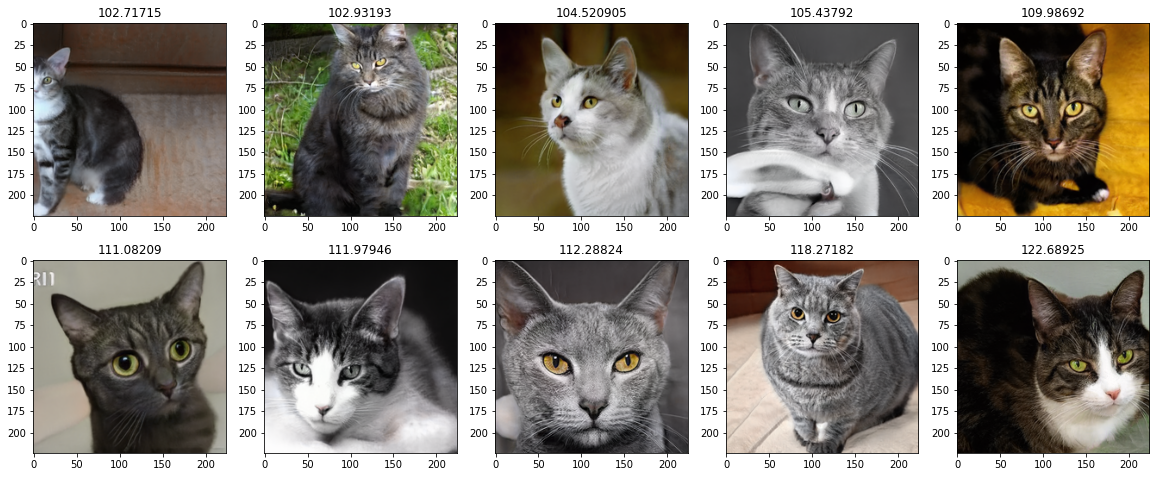

In [33]:
print("Scores of top 10 best cat images:")
recalculate_scores(theta)

## Second loop

In [34]:
pathx_high = "dirX_high"
pathy_high = "dirY_high"

output_x = '/content/drive/MyDrive/dataset/dirX_high.zip'
output_y = '/content/drive/MyDrive/dataset/dirY_high.zip'

with zipfile.ZipFile(output_x, 'r') as zip_ref:
    zip_ref.extractall('{}'.format(output_dir))

with zipfile.ZipFile(output_y, 'r') as zip_ref:
    zip_ref.extractall('{}'.format(output_dir))

In [35]:
X_loop_dir = natsort.natsorted(glob.glob(os.path.join(output_dir, pathx_high, '*.png')))
X_loop = resize(X_loop_dir, input_size)

Y_loop_dir = natsort.natsorted(glob.glob(os.path.join(output_dir, pathy_high, '*.png')))
Y_loop = resize(Y_loop_dir, input_size)

len(X_loop), len(Y_loop)

(59, 59)

In [36]:
# Adjust labels after asking for additional user labels
# posOnes = [5,6,8,9,10,11,13,14,15,16,17,19,21,22,28,29,32,36,37,38,39,42,43,44,45,46,47,48,49,50,52,53,55,56,58,59,62,63,64,65,67,69,70,71,73,74,76,79,80,81,86,89] # 0 <s< 50
posOnes = [2,3,6,13,16,18,22,23,24,25,27,31,33,34,39,40,42,43,44,45,46,47,48,50,51,53,54,56,57,59]
ones = [pos - 1 for pos in posOnes]
M = min(len(X_loop), len(Y_loop))

D = np.zeros(shape=(M,n_features))
for i in ones:
    D[i] = [1] * len(D[i])

output_X_loop = get_network_output(np.array(X_loop[:M]))
output_Y_loop = get_network_output(np.array(Y_loop[:M]))
output_X_loop.shape, output_Y_loop.shape

(TensorShape([59, 1280]), TensorShape([59, 1280]))

In [37]:
print("Scores of human-labelled images before loop: ")
print("Preferred: ", calculate_dir_scores([output_X_loop[i] for i in ones]))
print("Not preferred: ", calculate_dir_scores([output_Y_loop[i] for i in ones]))

Scores of human-labelled images before loop: 
Preferred:  2337.527332305908
Not preferred:  2055.267776489258


In [38]:
output_images_X = tf.concat([output_images_X, output_X_loop], 0)
output_images_Y = tf.concat([output_images_Y, output_Y_loop], 0)
print(output_images_X.shape, output_images_Y.shape)

C = np.concatenate((C,D), 0)
print(C.shape)

N += M
print(N)

(612, 1280) (612, 1280)
(612, 1280)
612


In [39]:
# Re-training and updating theta
def neg_loglikelihood_opt():
  log_likelihood = 1 / N * tf.reduce_sum(tf.math.log(tf.sigmoid((2 * C - 1) * (tf.transpose(theta) * output_images_X - tf.transpose(theta) * output_images_Y))))
  return -log_likelihood

opt = tf.keras.optimizers.SGD(learning_rate=0.5)
epochs = 501
for i in range(epochs):
  opt.minimize(neg_loglikelihood_opt, var_list=[theta])
  if i % 100 == 0:
    print('Loss at epoch {} = {}'.format(i,neg_loglikelihood_opt().numpy()))

theta

Loss at epoch 0 = 872.4033203125
Loss at epoch 100 = 872.237548828125
Loss at epoch 200 = 872.2218017578125
Loss at epoch 300 = 872.2161254882812
Loss at epoch 400 = 872.2132568359375
Loss at epoch 500 = 872.2117919921875


<tf.Variable 'Variable:0' shape=(1280, 1) dtype=float32, numpy=
array([[-0.31074846],
       [ 0.2356866 ],
       [ 0.47832906],
       ...,
       [ 0.47886437],
       [-0.54958326],
       [-2.0964081 ]], dtype=float32)>

In [40]:
print("Scores of human-labelled images after loop: ")
print("Preferred: ", calculate_dir_scores([output_X_loop[i] for i in ones]))
print("Not preferred: ", calculate_dir_scores([output_Y_loop[i] for i in ones]))

Scores of human-labelled images after loop: 
Preferred:  2330.626625061035
Not preferred:  1915.4452514648438


Scores of top 5 best cat images:


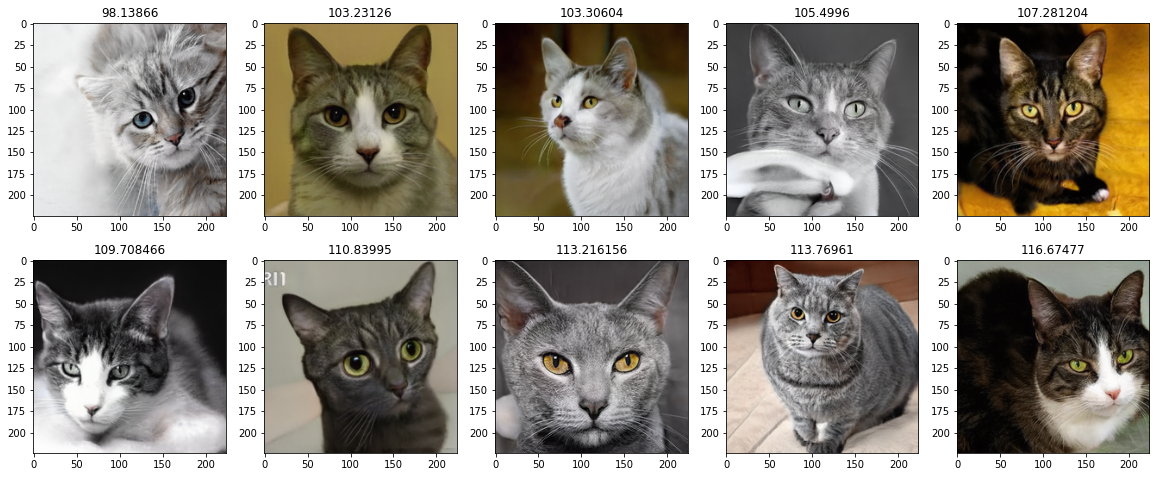

In [41]:
print("Scores of top 5 best cat images:")
recalculate_scores(theta)

## Third loop

In [42]:
pathx_higher = "dirX_higher"
pathy_higher = "dirY_higher"

output_x = '/content/drive/MyDrive/dataset/dirX_higher.zip'
output_y = '/content/drive/MyDrive/dataset/dirY_higher.zip'

with zipfile.ZipFile(output_x, 'r') as zip_ref:
    zip_ref.extractall('{}'.format(output_dir))

with zipfile.ZipFile(output_y, 'r') as zip_ref:
    zip_ref.extractall('{}'.format(output_dir))

In [43]:
X_loop_dir = natsort.natsorted(glob.glob(os.path.join(output_dir, pathx_higher, '*.png')))
X_loop = resize(X_loop_dir, input_size)

Y_loop_dir = natsort.natsorted(glob.glob(os.path.join(output_dir, pathy_higher, '*.png')))
Y_loop = resize(Y_loop_dir, input_size)

len(X_loop), len(Y_loop)

(51, 50)

In [44]:
# Adjust labels after asking for user labels
posOnes = [4,5,6,7,10,11,12,13,14,16,18,19,21,24,25,26,28,30,32,34,38,39,42,43,44]
ones = [pos - 1 for pos in posOnes]
M = min(len(X_loop), len(Y_loop))

D = np.zeros(shape=(M,n_features))
for i in ones:
    D[i] = [1] * len(D[i])

output_X_loop = get_network_output(np.array(X_loop[:M]))
output_Y_loop = get_network_output(np.array(Y_loop[:M]))
output_X_loop.shape, output_Y_loop.shape

(TensorShape([50, 1280]), TensorShape([50, 1280]))

In [45]:
print("Scores of human-labelled images before loop: ")
print("Preferred: ", calculate_dir_scores([output_X_loop[i] for i in ones]))
print("Not preferred: ", calculate_dir_scores([output_Y_loop[i] for i in ones]))

Scores of human-labelled images before loop: 
Preferred:  343.9266799688339
Not preferred:  409.53699791431427


In [46]:
output_images_X = tf.concat([output_images_X, output_X_loop], 0)
output_images_Y = tf.concat([output_images_Y, output_Y_loop], 0)
print(output_images_X.shape, output_images_Y.shape)

C = np.concatenate((C,D), 0)
print(C.shape)

N += M
print(N)

(662, 1280) (662, 1280)
(662, 1280)
662


In [47]:
# Re-training and updating theta
def neg_loglikelihood_opt():
  log_likelihood = 1 / N * tf.reduce_sum(tf.math.log(tf.sigmoid((2 * C - 1) * (tf.transpose(theta) * output_images_X- tf.transpose(theta) * output_images_Y))))
  return -log_likelihood

opt = tf.keras.optimizers.SGD(learning_rate=0.3)
epochs = 501
for i in range(epochs):
  opt.minimize(neg_loglikelihood_opt, var_list=[theta])
  if i % 100 == 0:
    print('Loss at epoch {} = {}'.format(i,neg_loglikelihood_opt().numpy()))

theta

Loss at epoch 0 = 874.4193725585938
Loss at epoch 100 = 874.3073120117188
Loss at epoch 200 = 874.2850952148438
Loss at epoch 300 = 874.2762451171875
Loss at epoch 400 = 874.27197265625
Loss at epoch 500 = 874.26953125


<tf.Variable 'Variable:0' shape=(1280, 1) dtype=float32, numpy=
array([[-0.23709916],
       [ 0.21994725],
       [ 0.47892916],
       ...,
       [ 0.46542466],
       [-0.45553604],
       [-1.871566  ]], dtype=float32)>

In [48]:
print("Scores of human-labelled images after loop: ")
print("Preferred: ", calculate_dir_scores([output_X_loop[i] for i in ones]))
print("Not preferred: ", calculate_dir_scores([output_Y_loop[i] for i in ones]))

Scores of human-labelled images after loop: 
Preferred:  385.2026345729828
Not preferred:  375.677161693573


Scores of top 5 best cat images:


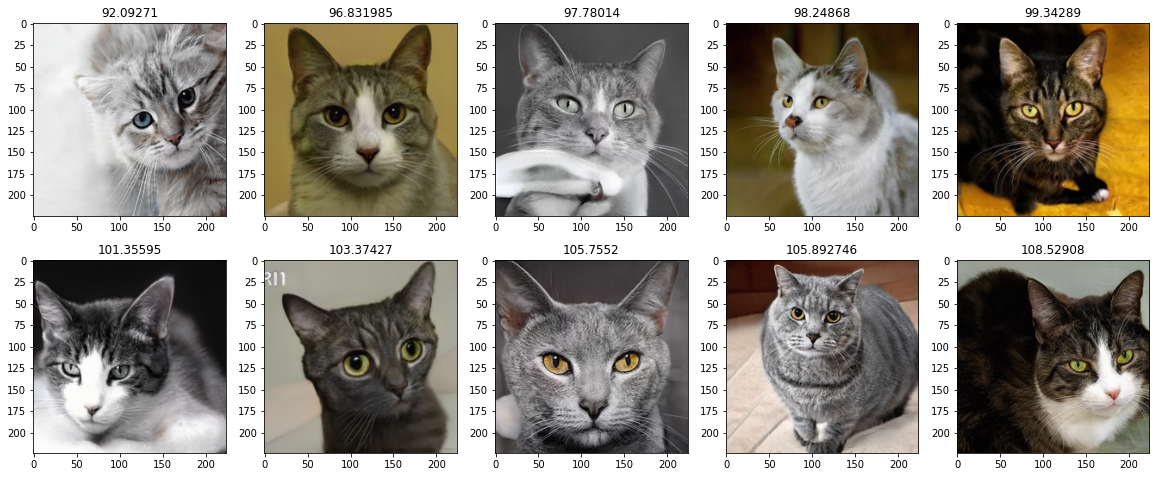

In [49]:
print("Scores of top 5 best cat images:")
recalculate_scores(theta)

In [51]:
output_reals = get_network_output(np.array(cat_datas[:200]))
output_dogs = get_network_output(np.array(dog_datas[:200]))
def compare_dataset_scores():
  fig = plt.figure(figsize=(20, 8))
  total_score_fake = 0
  total_score_real = 0
  total_score_dogs = 0
  for i in range(200):
      total_score_real += np.matmul(tf.transpose(theta), output_reals[i])[0]
      total_score_fake += np.matmul(tf.transpose(theta), output_GANS_test[i])[0]
      total_score_dogs += np.matmul(tf.transpose(theta), output_dogs[i])[0]

  print("Fakes: " + str(total_score_fake))
  print("Reals: " + str(total_score_real))
  print("Dogs: " + str(total_score_dogs))

compare_dataset_scores()

Fakes: -1511.452235519886
Reals: 11143.34366941452
Dogs: -11885.56105875969


<Figure size 1440x576 with 0 Axes>

#Testing with unseen GAN dataset

In [52]:
cats_gans_unseen = '/content/drive/MyDrive/dataset/cats_unseen.zip'
with zipfile.ZipFile(cats_gans_unseen, 'r') as zip_ref:
    zip_ref.extractall('cats_unseen')

cats_gans_unseen = resize(natsort.natsorted(glob.glob('cats_unseen/013000/*.png'))[:500], input_size)
output_unseen = get_network_output(np.array(cats_gans_unseen))

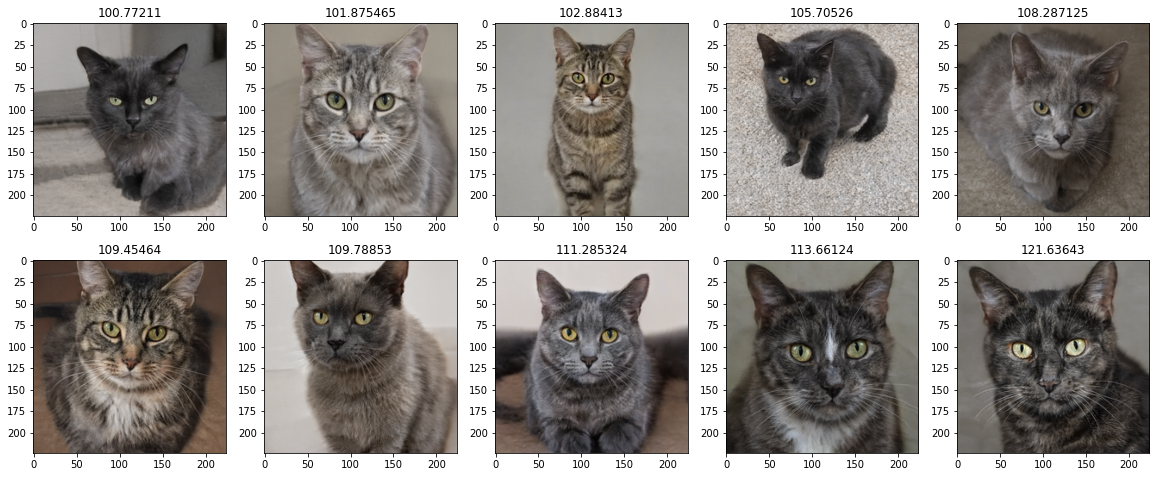

In [53]:
# Calculate scores for all images
all_scores = {}
for i in range(len(cats_gans_unseen)):
    score = np.matmul(tf.transpose(theta), output_unseen[i])[0]
    all_scores[score] = cats_gans_unseen[i].astype("uint8")

# Display best 10 images
fig = plt.figure(figsize=(20, 8))
i = 0
for k, v in sorted(all_scores.items())[-10:]:
    ax = plt.subplot(2, 5, i+1)
    plt.title(k)
    plt.imshow(v)
    i += 1

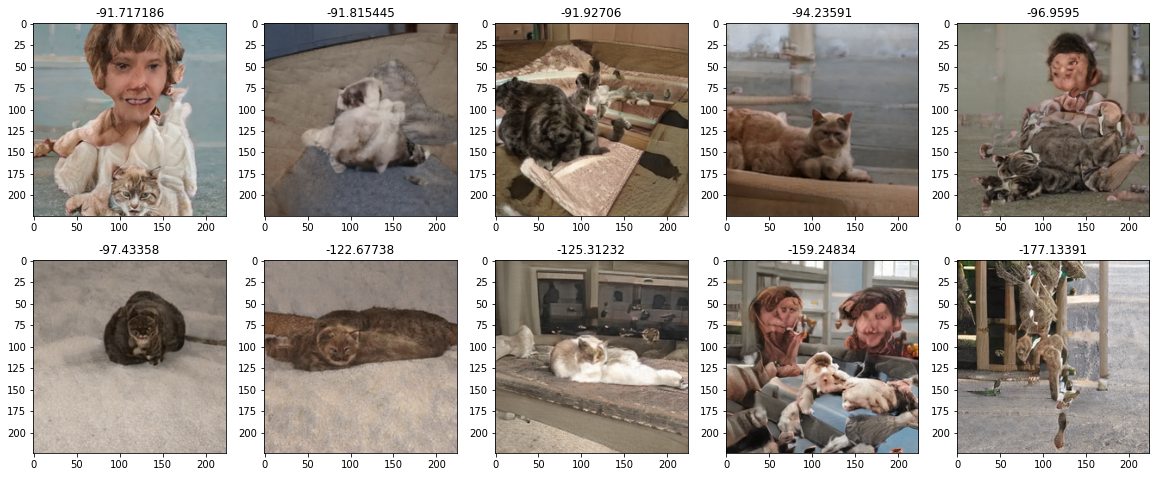

In [54]:
# Display worst 10 images
fig = plt.figure(figsize=(20, 8))
i = 0
for k, v in sorted(all_scores.items(), reverse=True)[-10:]:
    ax = plt.subplot(2, 5, i+1)
    plt.title(k)
    plt.imshow(v)
    i += 1

In [55]:
output_reals = get_network_output(np.array(cat_datas[:200]))
output_dogs = get_network_output(np.array(dog_datas[:200]))
def compare_dataset_scores():
  fig = plt.figure(figsize=(20, 8))
  total_score_fake = 0
  total_score_real = 0
  total_score_dogs = 0
  for i in range(200):
      total_score_real += np.matmul(tf.transpose(theta), output_reals[i])[0]
      total_score_fake += np.matmul(tf.transpose(theta), output_unseen[i])[0]
      total_score_dogs += np.matmul(tf.transpose(theta), output_dogs[i])[0]

  print("Fakes: " + str(total_score_fake))
  print("Reals: " + str(total_score_real))
  print("Dogs: " + str(total_score_dogs))

compare_dataset_scores()

Fakes: 8797.790494918823
Reals: 11143.34366941452
Dogs: -11885.56105875969


<Figure size 1440x576 with 0 Axes>

# Example of originally distuinguishable images, now distuinguishable after training loop#

In [56]:
#output_rec_x = get_network_output(np.array(resize(glob.glob('32_im_50.png'), (224,224))))
#output_rec_y = get_network_output(np.array(resize(glob.glob('34_im_49.png'), (224,224))))

#output_rec_x = get_network_output(np.array(resize(glob.glob('374_im_51.png'), (224,224))))
#output_rec_y = get_network_output(np.array(resize(glob.glob('251_im_5.png'), (224,224))))

output_rec_x = get_network_output(np.array(resize(glob.glob('508_im_62.png'), (224,224))))
output_rec_y = get_network_output(np.array(resize(glob.glob('518_im_43.png'), (224,224))))

np.matmul(tf.transpose(theta), output_rec_x[0])[0], np.matmul(tf.transpose(theta), output_rec_y[0])[0]

(nan, nan)

# Old code for image comparison

In [57]:
# !rm -rf "/content/outputs/dirY_high.zip"
# !rm -rf "/content/outputs/dirX_high.zip"
# !rm -rf "/content/outputs/dirY_high"
# !rm -rf "/content/outputs/dirX_high"
# !rm -rf "/content/outputs"

In [58]:
# output_dir = 'outputs'
# pathx_low = "dirX_low"
# pathy_low = "dirY_low"

# if not os.path.isdir(output_dir):
#   os.mkdir(output_dir)

# if not os.path.isdir(os.path.join(output_dir, pathx_low)):
#   os.mkdir(os.path.join(output_dir, pathx_low)) 

# if not os.path.isdir(os.path.join(output_dir, pathy_low)):
#   os.mkdir(os.path.join(output_dir, pathy_low))

# toggle = True
# numCompares = 0
# for i in range(len(cats_gans_test)):
#   score = np.matmul(tf.transpose(theta), output_GANS_test[i])[0]
#   if numCompares >= 200:
#     break
#   if -50 < score < 0:
#     numCompares += 1
#     im = Image.fromarray(cats_gans_test[i])
#     if toggle:
#       im.save(os.path.join(output_dir, pathx_low, "{}_im_{}.png".format(i, int(score))))
#     else:
#       im.save(os.path.join(output_dir, pathy_low, "{}_im_{}.png".format(i, int(score))))
#     toggle = not toggle

# # Zip up files for comparison
# !zip -r /content/outputs/dirX_low.zip /content/outputs/dirX_low
# !zip -r /content/outputs/dirY_low.zip /content/outputs/dirY_low

# # Downdload files for human comparison
# from google.colab import files
# files.download(os.path.join(output_dir, "{}.zip".format(pathx_low))) 
# files.download(os.path.join(output_dir, "{}.zip".format(pathy_low)))

In [59]:
# pathx_high = 'dirX_high'
# pathy_high = 'dirY_high'

# if not os.path.isdir(os.path.join(output_dir, pathx_high)):
#   os.mkdir(os.path.join(output_dir, pathx_high)) 

# if not os.path.isdir(os.path.join(output_dir, pathy_high)):
#   os.mkdir(os.path.join(output_dir, pathy_high))

# toggle = True
# numCompares = 0
# for i in range(len(cats_gans_test)):
#   score = np.matmul(tf.transpose(theta), output_GANS_test[i])[0]
#   if numCompares >= 200: # Limit comparison numbers for user
#     break
#   if 0 < score < 50:
#     numCompares += 1
#     im = Image.fromarray(cats_gans_test[i])
#     if toggle:
#       im.save(os.path.join(output_dir, pathx_high, "{}_im_{}.png".format(i, int(score))))
#     else:
#       im.save(os.path.join(output_dir, pathy_high, "{}_im_{}.png".format(i, int(score))))
#     toggle = not toggle

# # Download file for human comparison
# !zip -r /content/outputs/dirX_high.zip /content/outputs/dirX_high
# !zip -r /content/outputs/dirY_high.zip /content/outputs/dirY_high

# from google.colab import files
# files.download("/content/outputs/dirX_high.zip")
# files.download("/content/outputs/dirY_high.zip")

In [60]:
# pathx_higher = 'dirX_higher'
# pathy_higher = 'dirY_higher'

# if not os.path.isdir(os.path.join(output_dir, pathx_higher)):
#   os.mkdir(os.path.join(output_dir, pathx_higher)) 

# if not os.path.isdir(os.path.join(output_dir, pathy_higher)):
#   os.mkdir(os.path.join(output_dir, pathy_higher))

# toggle = True
# numCompares = 0
# for i in range(len(cats_gans_test)):
#   score = np.matmul(tf.transpose(theta), output_GANS_test[i])[0]
#   if numCompares >= 200: # Limit comparison numbers for user
#     break
#   if 0 < score < 30:
#     numCompares += 1
#     im = Image.fromarray(cats_gans_test[i])
#     if toggle:
#       im.save(os.path.join(output_dir, pathx_higher, "{}_im_{}.png".format(i, int(score))))
#     else:
#       im.save(os.path.join(output_dir, pathy_higher, "{}_im_{}.png".format(i, int(score))))
#     toggle = not toggle

# # Download file for human comparison
# !zip -r /content/outputs/dirX_higher.zip /content/outputs/dirX_higher
# !zip -r /content/outputs/dirY_higher.zip /content/outputs/dirY_higher

# files.download("/content/outputs/dirX_higher.zip")
# files.download("/content/outputs/dirY_higher.zip")